In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

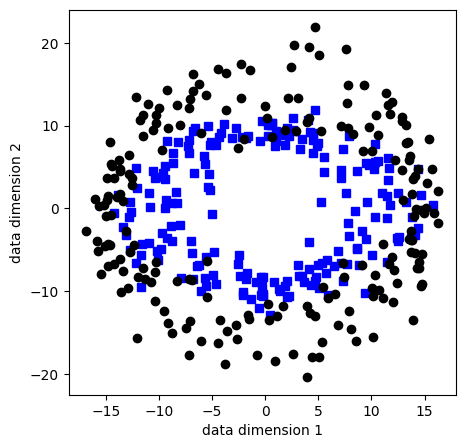

In [31]:
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.xlabel('data dimension 1')
plt.ylabel('data dimension 2')
plt.show()

In [32]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 16
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [33]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        self.input = nn.Linear(2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128,1)

        self.dr = dropoutRate

    def forward(self, x):
        x = F.relu(self.input(x))

        x = F.dropout(x, p=self.dr, training=self.training)

        x = F.relu(self.hidden(x))

        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)

        return x

In [34]:
tmpnet = theModelClass(0.25)

tmpdata = torch.randn((10,2))

yHat = tmpnet(tmpdata)
yHat

tensor([[ 0.0094],
        [ 0.0150],
        [ 0.0365],
        [-0.1046],
        [ 0.0471],
        [-0.1348],
        [ 0.0681],
        [-0.0579],
        [ 0.0261],
        [-0.0519]], grad_fn=<AddmmBackward0>)

In [35]:
def createTheModel(dropoutRate):
    ANN = theModelClass(dropoutRate)

    lossfun = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=.002)

    return ANN, lossfun, optimizer

In [36]:
numEpochs = 1000

def trainTheModel(ANN, lossfun, optimizer):
    trainAcc = []
    testAcc = []

    for epochi in range(numEpochs):
        ANN.train()

        batchAcc = []
        for X, y in train_loader:
            yHat = ANN(X)

            loss = lossfun(yHat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

        trainAcc.append(np.mean(batchAcc))

        ANN.eval()
        X,y = next(iter(test_loader))
        yHat = ANN(X)
        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

    return trainAcc, testAcc

In [37]:
dropoutRate = .0
ANN, lossfun, optimizer = createTheModel(dropoutRate)

trainAcc, testAcc = trainTheModel(ANN, lossfun, optimizer)

In [38]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

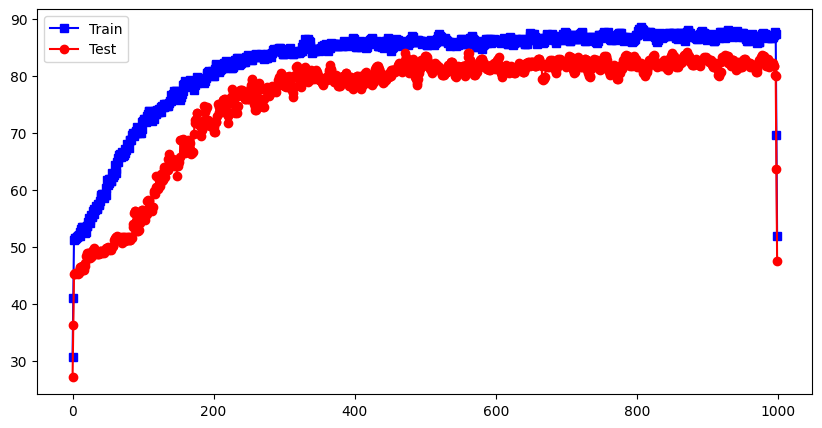

In [39]:
fig = plt.figure(figsize=(10,5))
plt.plot(smooth(trainAcc), 'bs-')
plt.plot(smooth(testAcc), 'ro-')
plt.legend(['Train', 'Test'])
plt.show()

In [40]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for dp in range(len(results)):
    ANN, lossfun, optimizer = createTheModel(dropoutRates[dp])
    trainAcc, testAcc = trainTheModel(ANN, lossfun, optimizer)

    results[dp, 0] = np.mean(trainAcc[-100:])
    results[dp, 1] = np.mean(testAcc[-100:])

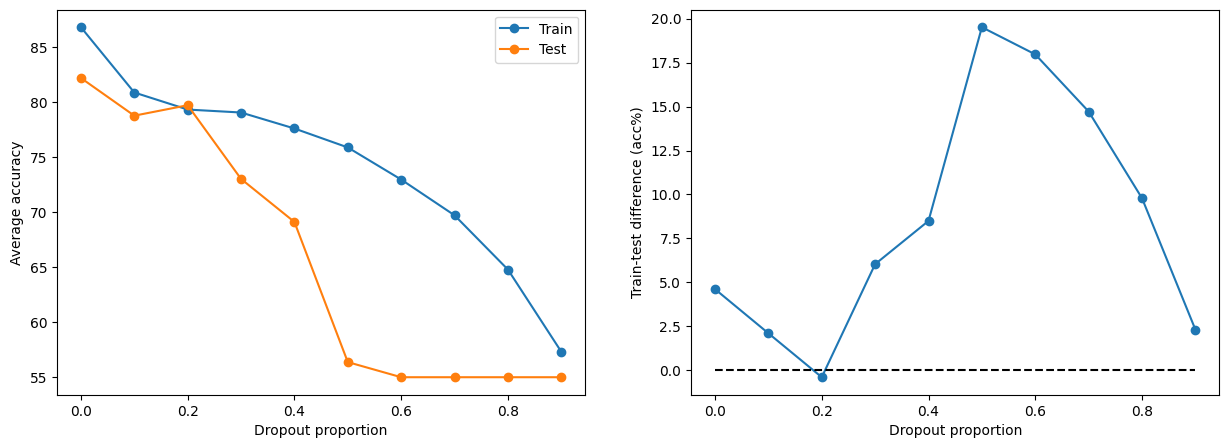

In [41]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()